# Dog Breed Identification

This example is based on a very popular [Udacity project](https://github.com/udacity/dog-project). The goal is to classify images of dogs according to their breed.  

In this notebook, you will take the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks.

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Install requirements & download datasets
* [Step 1](#step1): Import Datasets
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN (VGG16) to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN (ResNet-50) to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---

<a id='step0'></a>
## Step 0: Install requirements & download datasets

### Download datasets

In [ ]:
# Download and unzip the dog dataset
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip -qo dogImages.zip
!rm dogImages.zip

In [ ]:
# Download the VGG-16 bottleneck features for the dog dataset
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG16Data.npz -O bottleneck_features/DogVGG16Data.npz

In [ ]:
# Download the ResNet50 features for the dog dataset
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz -O bottleneck_features/DogResnet50Data.npz

### Below is the `imports` cell. This is where we import all the necessary libraries

In [2]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

import os
import random

import cv2                
import matplotlib.pyplot as plt

from keras.applications.resnet50 import ResNet50

from keras.preprocessing import image                  
from tqdm import tqdm

from keras.applications.resnet50 import preprocess_input, decode_predictions

from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

from keras.callbacks import ModelCheckpoint

import extract_bottleneck_features as ebf

from keras import optimizers

Using TensorFlow backend.


### Install requirements

In [ ]:
!pip3 install --user -r requirements/requirements.txt

### Pipeline Parameters

This is the `pipeline-parameters` cell. Use it to define the parameters you will use for hyperparameter tuning. These variables will be converted to KFP pipeline parameters, so make sure they are used as global variables throughout the notebook.

In [3]:
nodes_number = 256
learning_rate = 0.0001

<a id='step1'></a>
## Step 1: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating label

In [4]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

In [5]:
# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 5 total dog categories.
There are 40 total dog images.
There are 30 training dog images.
There are 5 validation dog images.
There are 5 test dog images.


In [6]:
dog_files_short = train_files[:100]

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [7]:
# define ResNet50 model
ResNet50_mod = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [8]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [9]:
def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_mod.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [10]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### Assess the Dog Detector

We use the code cell below to test the performance of the `dog_detector` function.    
- What percentage of the images in `dog_files_short` have a detected dog?

In [11]:
n_dog = np.sum([dog_detector(img) for img in dog_files_short])

dog_percentage = n_dog/len(dog_files_short)

print('{:.0%} of the files have a detected dog'.format(dog_percentage))

100% of the files have a detected dog


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have a function for detecting dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In later steps, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  


Yellow Labrador | Chocolate Labrador | Black Labrador  
- | - | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">


We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [12]:
# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 5/5 [00:00<00:00, 367.21it/s]


### Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

Here is a sample architecture of such a model:

![Sample CNN](images/sample_cnn.png)

In [13]:
# Define the model architecture

model = Sequential()

model.add(Conv2D(input_shape=train_tensors.shape[1:],filters=16,kernel_size=2, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(filters=32,kernel_size=2, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(filters=64,kernel_size=2, activation='relu'))
model.add(MaxPooling2D())
model.add(GlobalAveragePooling2D())
model.add(Dense(133,activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

### Compile the Model

In [14]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

In [15]:
### specify the number of epochs that you would like to use to train the model.

# Train for 20 epochs only when using a GPU, otherwise it will take a lot of time
# epochs = 20

# Train for 1 epoch when using a CPU.
epochs = 1

os.makedirs('saved_models', exist_ok=True)
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=32, callbacks=[checkpointer], verbose=1)

Train on 30 samples, validate on 5 samples
Epoch 1/1
Epoch 00000: val_loss improved from inf to 4.81706, saving model to saved_models/weights.best.from_scratch.hdf5
30/30 [==============================] - 1s - loss: 4.9359 - acc: 0.0000e+00 - val_loss: 4.8171 - val_acc: 0.0000e+00


### Load the Model with the Best Validation Loss

In [16]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [17]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 0.0000%


---
<a id='step4'></a>
## Step 4: Create a CNN (VGG16) to Classify Dog Breeds (using Transfer Learning)

To reduce training time without sacrificing accuracy, we show you how to train a CNN using Transfer Learning.  In the following step, you will get a chance to use Transfer Learning to train your own CNN.

Transfer Learning is a fine-tuning of a network that was pre-trained on some big dataset with new classification layers. The idea behind is that we want to keep all the good features learned in the lower levels of the network (because there's a high probability the new images will also have those features) and just learn a new classifier on top of those. This tends to work well, especially with small datasets that don't allow for a full training of the network from scratch (it's also much faster than a full training).

One way of doing Transfer Learning is by using bottlenecks. A bottleneck, also called embedding, is the internal representation of one of the input samples in the network, at a certain depth level. We can think of a bottleneck at level N as the output of the network stopped after N layers. Why is this useful? Because we can precompute the bottlenecks for all our samples using a pre-trained network and then simulate the training of only the last layers of the network without having to actually recompute all the (expensive) parts up to the bottleneck point.

Here we will uses pre-computed bottlenecks, but if you want to take a look at how you could generate them yourself, take a look [here](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).

### Obtain Bottleneck Features

In [18]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 architecture as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [19]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [20]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [21]:
os.makedirs('saved_models', exist_ok=True)
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=32, callbacks=[checkpointer], verbose=1)

Train on 30 samples, validate on 5 samples
Epoch 1/20
Epoch 00000: val_loss improved from inf to 14.73107, saving model to saved_models/weights.best.VGG16.hdf5
30/30 [==============================] - 0s - loss: 15.5912 - acc: 0.0000e+00 - val_loss: 14.7311 - val_acc: 0.0000e+00
Epoch 2/20
Epoch 00001: val_loss improved from 14.73107 to 11.10415, saving model to saved_models/weights.best.VGG16.hdf5
30/30 [==============================] - 0s - loss: 13.5682 - acc: 0.0333 - val_loss: 11.1041 - val_acc: 0.2000
Epoch 3/20
Epoch 00002: val_loss improved from 11.10415 to 9.76344, saving model to saved_models/weights.best.VGG16.hdf5
30/30 [==============================] - 0s - loss: 10.6940 - acc: 0.2333 - val_loss: 9.7634 - val_acc: 0.2000
Epoch 4/20
Epoch 00003: val_loss improved from 9.76344 to 8.16991, saving model to saved_models/weights.best.VGG16.hdf5
30/30 [==============================] - 0s - loss: 8.6238 - acc: 0.3000 - val_loss: 8.1699 - val_acc: 0.0000e+00
Epoch 5/20
Epoch 000

### Load the Model with the Best Validation Loss

In [22]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [23]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 0.0000%


### Predict Dog Breed with the Model

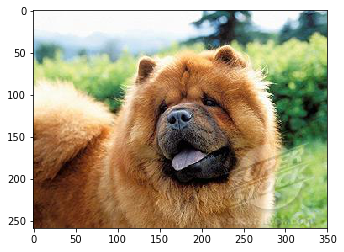

Groundtruth dog breed: Chow_chow
Predicted dog breed: Australian_shepherd


In [34]:
def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = ebf.extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)].split('.')[-1]

# Show first dog image
img_path = test_files[0]
img = cv2.imread(img_path)
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(cv_rgb)
plt.show()

# Print groundtruth and predicted dog breed
gtruth = np.argmax(test_targets[0])
gtruth = dog_names[gtruth].split('.')[-1]
pred = VGG16_predict_breed(img_path)
print("Groundtruth dog breed: {}".format(gtruth))
print("Predicted dog breed: {}".format(pred))

---
<a id='step5'></a>
## Step 5: Create a CNN (ResNet-50) to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, we will use the bottleneck features from a different pre-trained model.

### Obtain Bottleneck Features


In [25]:
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_ResNet50 = bottleneck_features['train']
valid_ResNet50 = bottleneck_features['valid']
test_ResNet50 = bottleneck_features['test']

### Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model.

In [26]:
ResNet50_model = Sequential()

ResNet50_model.add(Flatten(input_shape=train_ResNet50.shape[1:]))
# The layer below includes a hyperparameter (nodes_number)
ResNet50_model.add(Dense(nodes_number, activation='relu'))
ResNet50_model.add(Dense(133, activation='softmax'))

# Summarize the layers of the model
ResNet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_4 (Dense)              (None, 133)               34181     
Total params: 558,725.0
Trainable params: 558,725.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [27]:
### Learning rate (learning_rate) is a hyperparameter in this example

opt = optimizers.Adam(learning_rate)
ResNet50_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

### Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

In [28]:
os.makedirs('saved_models', exist_ok=True)
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.ResNet50.hdf5', 
                               verbose=1, save_best_only=True)

### Train the model.
ResNet50_model.fit(train_ResNet50, train_targets, 
          validation_data=(valid_ResNet50, valid_targets),
          epochs=20, batch_size=32, callbacks=[checkpointer], verbose=1)

Train on 30 samples, validate on 5 samples
Epoch 1/20
Epoch 00000: val_loss improved from inf to 4.95512, saving model to saved_models/weights.best.ResNet50.hdf5
30/30 [==============================] - 0s - loss: 5.2378 - acc: 0.0000e+00 - val_loss: 4.9551 - val_acc: 0.0000e+00
Epoch 2/20
Epoch 00001: val_loss improved from 4.95512 to 4.73504, saving model to saved_models/weights.best.ResNet50.hdf5
30/30 [==============================] - 0s - loss: 4.9515 - acc: 0.0000e+00 - val_loss: 4.7350 - val_acc: 0.0000e+00
Epoch 3/20
Epoch 00002: val_loss improved from 4.73504 to 4.54495, saving model to saved_models/weights.best.ResNet50.hdf5
30/30 [==============================] - 0s - loss: 4.5775 - acc: 0.0667 - val_loss: 4.5450 - val_acc: 0.2000
Epoch 4/20
Epoch 00003: val_loss improved from 4.54495 to 4.35157, saving model to saved_models/weights.best.ResNet50.hdf5
30/30 [==============================] - 0s - loss: 4.2472 - acc: 0.1667 - val_loss: 4.3516 - val_acc: 0.2000
Epoch 5/20
Ep

### Load the Model with the Best Validation Loss

In [29]:
### Load the model weights with the best validation
ResNet50_model.load_weights('saved_models/weights.best.ResNet50.hdf5')

### Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [30]:
# get index of predicted dog breed for each image in test set
ResNet50_predictions = [np.argmax(ResNet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_ResNet50]

# report test accuracy
test_accuracy_resnet = 100*np.sum(np.array(ResNet50_predictions)==np.argmax(test_targets, axis=1))/len(ResNet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy_resnet)

Test accuracy: 20.0000%


### Predict Dog Breed with the Model

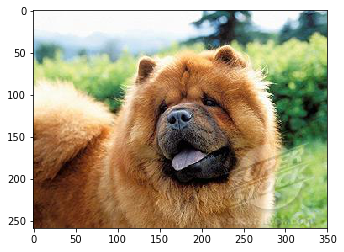

Groundtruth dog breed: Chow_chow
Predicted dog breed: Alaskan_malamute


In [31]:
def predict_breed(img_path):
    img = path_to_tensor(img_path)
    bottleneck_feature = ebf.extract_Resnet50(img)
    predicted = ResNet50_model.predict(bottleneck_feature)
    idx = np.argmax(predicted)
    return dog_names[idx].split('.')[-1]

# Show first dog image
img_path = test_files[0]
img = cv2.imread(img_path)
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(cv_rgb)
plt.show()

# Print groundtruth and predicted dog breed
gtruth = np.argmax(test_targets[0])
gtruth = dog_names[gtruth].split('.')[-1]
pred = predict_breed(img_path)
print("Groundtruth dog breed: {}".format(gtruth))
print("Predicted dog breed: {}".format(pred))

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a dog or not.  Then,
- if a __dog__ is detected in the image, return the predicted breed.

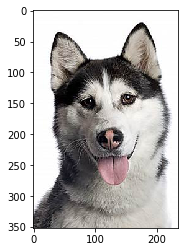

Dog detected
This photo looks like a(n) Alaskan_malamute


In [32]:
def return_breed(img_path):
    pred = None
    dog = False

    if dog_detector(img_path):
        dog = True
        print('Dog detected')
    else:
        print('No dog detected')

    if dog:
        pred = predict_breed(img_path)
        print('This photo looks like a(n) {}'.format(pred))

    return pred


# Run for the second dog image
img_path = test_files[1]
img = cv2.imread(img_path)
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(cv_rgb)
plt.show()
pred = return_breed(img_path)

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin! If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

check_images/alaskan_malamute.jpg


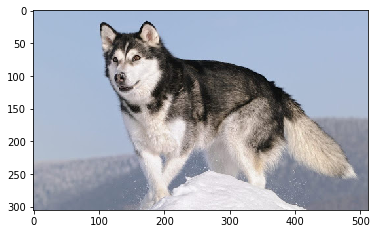

Dog detected
This photo looks like a(n) Alaskan_malamute
check_images/cat1.jpg


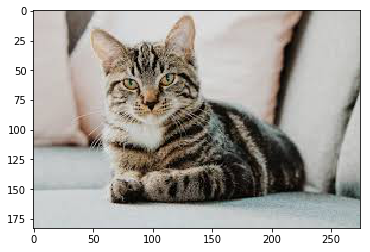

No dog detected
check_images/cat2.jpg


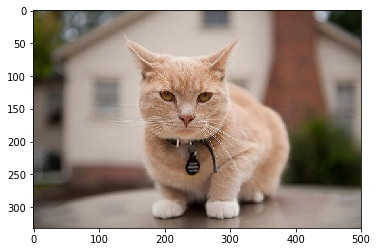

No dog detected
check_images/chow-chow.jpg


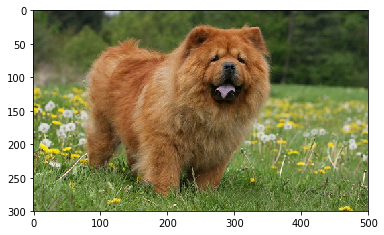

Dog detected
This photo looks like a(n) Alaskan_malamute
check_images/goat.jpg


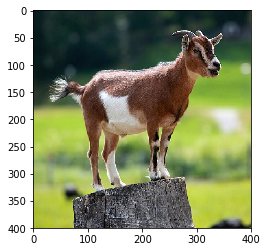

No dog detected
check_images/horse-dog.jpg


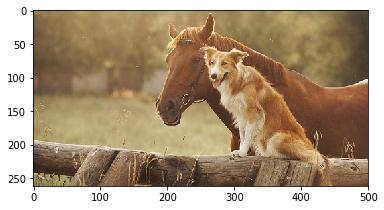

No dog detected
check_images/horse.jpg


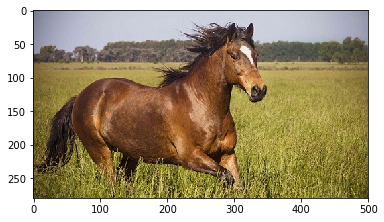

No dog detected
check_images/wolf.jpg


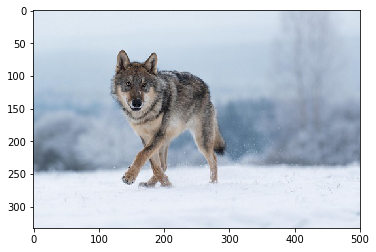

No dog detected


In [33]:
for img_path in sorted(glob("check_images/*")):
    print(img_path)
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()
    return_breed(img_path)

### Pipeline Metrics

This is the `pipeline-metrics` cell. Use it to define the pipeline metrics that KFP will produce for every pipeline run. Kale will associate each one of these metrics to the steps that produced them. Also, you will have to choose one these metrics as the Katib search objective metric.

In [ ]:
print(test_accuracy_resnet)